In [1]:
import sys
import os

# Add the path to the volatility_analysis directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, 'code', 'volatility_analysis'))
from volatility_pipeline import *

import torch
torch.set_grad_enabled(True)

In [2]:
# Configuration parameters
FETCH_DATA = False  # Set to True to fetch new news data
FROM = "2023-01-01"
TO = "2025-05-31"
CUT = "2024-10-01"  # Date to split train/test data
MARKET_NAME = "IBEX 35"
WINDOW = 7
EPOCHS = 200

In [3]:
# Define relevant keywords for IBEX 35 news
keywords = [
    "IBEX",  # IBEX 35
    "inflacion",  # Inflation
    "tipo de interes",  # Interest rates
    "aranceles",  # Tariffs
    "crecimiento economico",  # Economic growth
    "recesion",  # Recession
    "desempleo",  # Unemployment
    "subvenciones",  # Subsidies
    "inversion",  # Investment
    "expansion"  # Expansion
]

KEYWORDS = " OR ".join([f'"{keyword}"' for keyword in keywords])

In [4]:
import pandas as pd, time, random
from pygooglenews import GoogleNews

# Fetch news data function
def fetch_ibex_news_data():
    gn = GoogleNews(lang="es", country="ES")

    all_frames = []

    start_dt = pd.to_datetime(FROM)
    end_dt   = pd.to_datetime(TO)

    while start_dt <= end_dt:
        stop_dt = min(start_dt + pd.Timedelta(days=WINDOW-1), end_dt)

        feed    = gn.search(KEYWORDS,
                            from_=start_dt.strftime("%Y-%m-%d"),
                            to_  =stop_dt.strftime("%Y-%m-%d"))

        df      = pd.DataFrame(
                    {"date":  [pd.to_datetime(e.published).tz_localize(None)
                                for e in feed["entries"]],
                    "title": [e.title for e in feed["entries"]]}
                )
        all_frames.append(df)

        # polite pause to avoid 429 errors
        time.sleep(random.uniform(1.0, 2.5))
        start_dt = stop_dt + pd.Timedelta(days=1)

    news_df = (pd.concat(all_frames, ignore_index=True)
                .drop_duplicates())          # remove overlaps
    
    # Remove the "- name of the news source" suffix from titles
    news_df['title'] = news_df['title'].str.replace(r' - .+$', '', regex=True)
    

    # Save to CSV
    os.makedirs("../news", exist_ok=True)
    news_df.to_csv(f"../news/news_data_{FROM}_{TO}_IBEX.csv", index=False)
    
    return news_df

In [5]:
# Fetch or load news data
if FETCH_DATA:
    news_df = fetch_ibex_news_data()
    print(f"Fetched {len(news_df)} news articles")
else:
    # Read the CSV file
    news_df = pd.read_csv(f"../news/news_data_{FROM}_{TO}_IBEX.csv", parse_dates=['date'])
    print(f"Loaded {len(news_df)} news articles")

Loaded 12361 news articles


In [6]:
import yfinance

# Fetch IBEX 35 market data using yfinance
ibex35 = yfinance.Ticker("^IBEX")
ibex35_data = ibex35.history(start=FROM, end=TO, interval="1d", auto_adjust=True)
ibex35_data = ibex35_data.reset_index()  # Convert index to column
ibex35_data["Returns"] = ibex35_data["Close"].pct_change()
ibex35_data["Volatility"] = ibex35_data["Returns"].rolling(window=21).std() * np.sqrt(252)
ibex35_data = ibex35_data.dropna().reset_index(drop=True)

# Remove hours from the date
ibex35_data["Date"] = ibex35_data["Date"].dt.date
# Remove hours from the date in news_df
news_df["date"] = news_df["date"].dt.date

print(f"Loaded {len(ibex35_data)} days of IBEX 35 market data")

Loaded 594 days of IBEX 35 market data


Splitting data at 2024-10-01...
Sentiment model loaded on device: cuda
GPU: NVIDIA GeForce RTX 4070
Calculating enhanced sentiment scores...
Computing sentiment predictions from scratch...
Processing 12361 news titles in batches of 32
Computed and cached sentiment predictions for 870 dates
Plotting sentiment distribution...


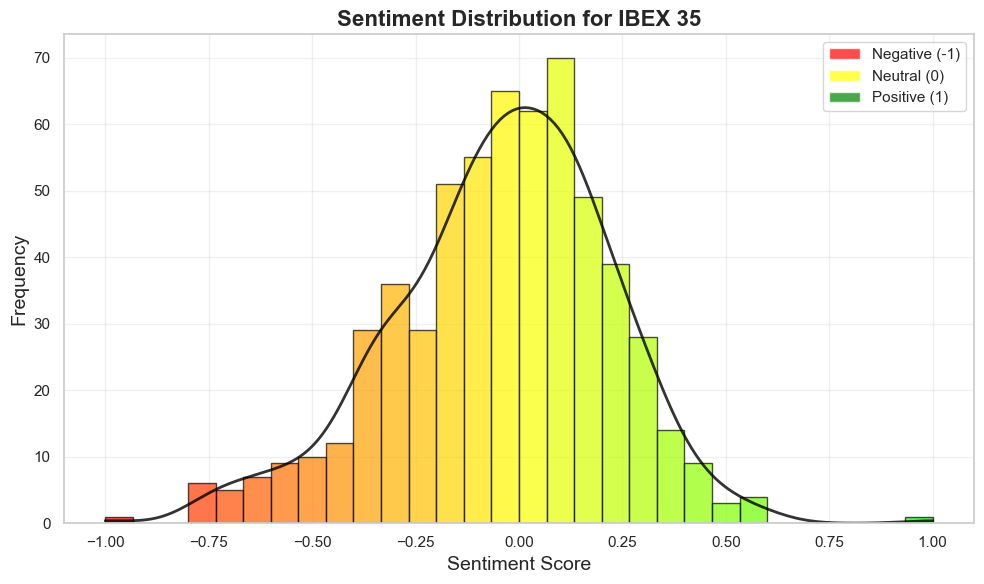

Final feature columns for model: ['Volatility_Smooth', 'sentiment_vol', 'sentiment_std_3d', 'sentiment_std_5d', 'sentiment_std_7d', 'sentiment_extreme']


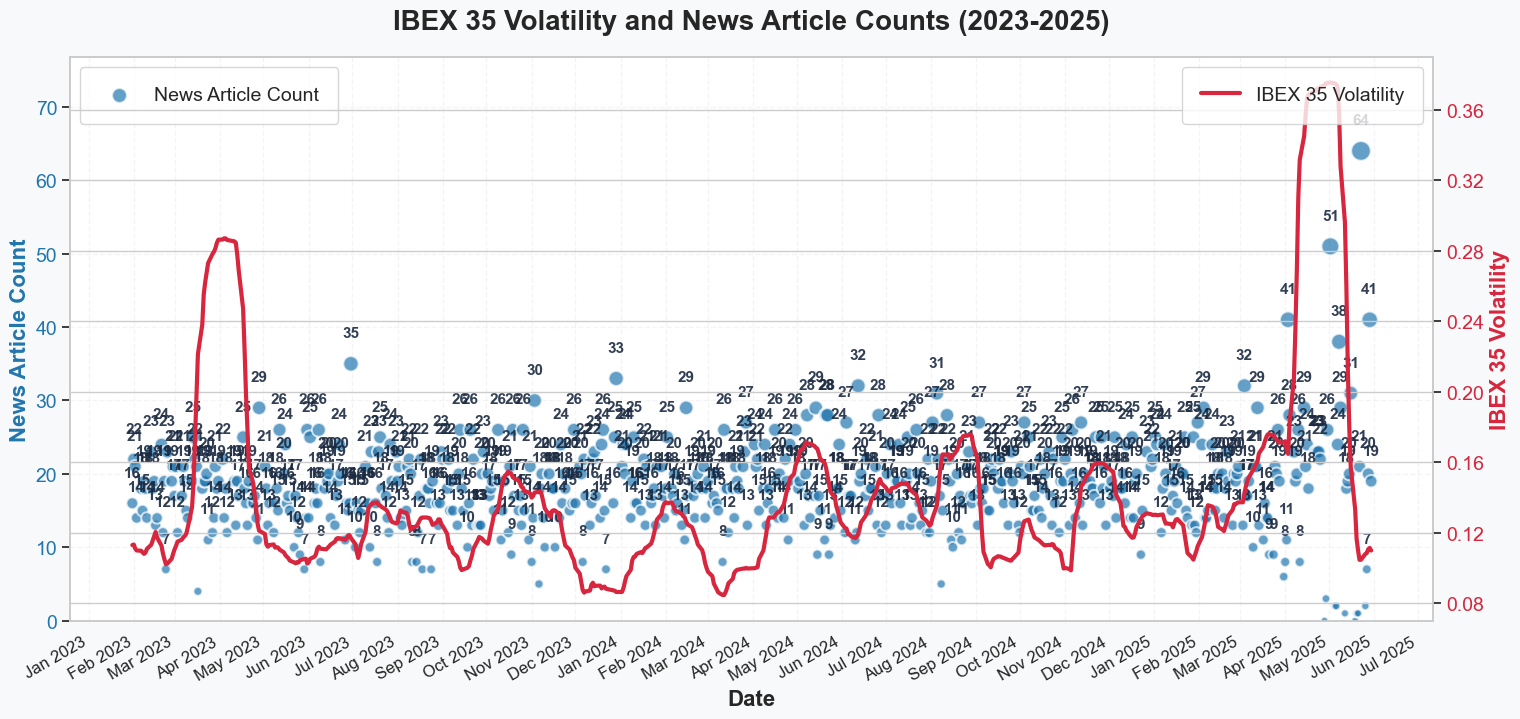

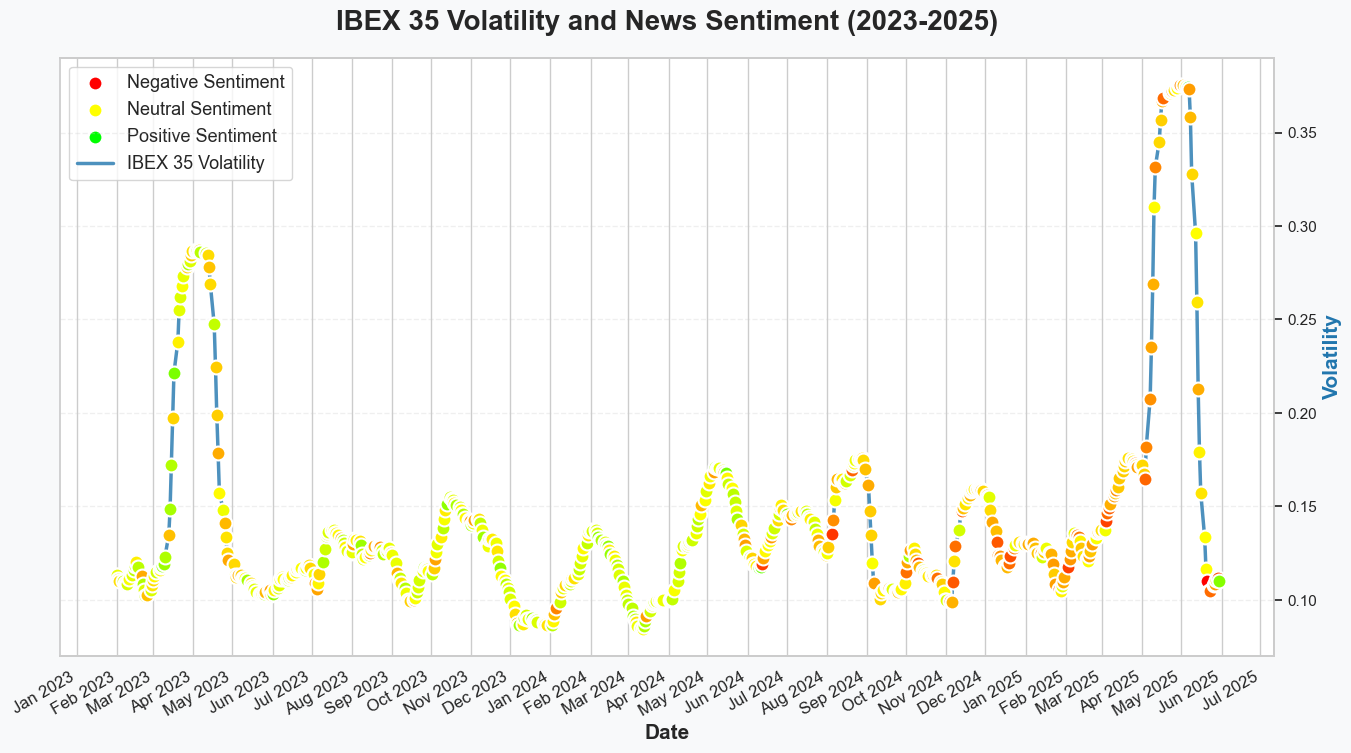

Preparing data for LSTM model...
Training enhanced LSTM model with early stopping...
Model initialized with 5314 trainable parameters
Epoch 1/200, Train Loss: 0.13483, Val Loss: 0.06231
Epoch 10/200, Train Loss: 0.00762, Val Loss: 0.00508
Epoch 20/200, Train Loss: 0.00438, Val Loss: 0.00306
Epoch 30/200, Train Loss: 0.00303, Val Loss: 0.00226
Epoch 40/200, Train Loss: 0.00194, Val Loss: 0.00166
Epoch 50/200, Train Loss: 0.00104, Val Loss: 0.00118
Epoch 60/200, Train Loss: 0.00079, Val Loss: 0.00106
Epoch 70/200, Train Loss: 0.00069, Val Loss: 0.00100
Epoch 80/200, Train Loss: 0.00062, Val Loss: 0.00095
Epoch 90/200, Train Loss: 0.00057, Val Loss: 0.00092
Epoch 100/200, Train Loss: 0.00053, Val Loss: 0.00089
Epoch 110/200, Train Loss: 0.00050, Val Loss: 0.00086
Epoch 120/200, Train Loss: 0.00047, Val Loss: 0.00084
Epoch 130/200, Train Loss: 0.00044, Val Loss: 0.00082
Epoch 140/200, Train Loss: 0.00042, Val Loss: 0.00080
Epoch 150/200, Train Loss: 0.00041, Val Loss: 0.00078
Epoch 160/200

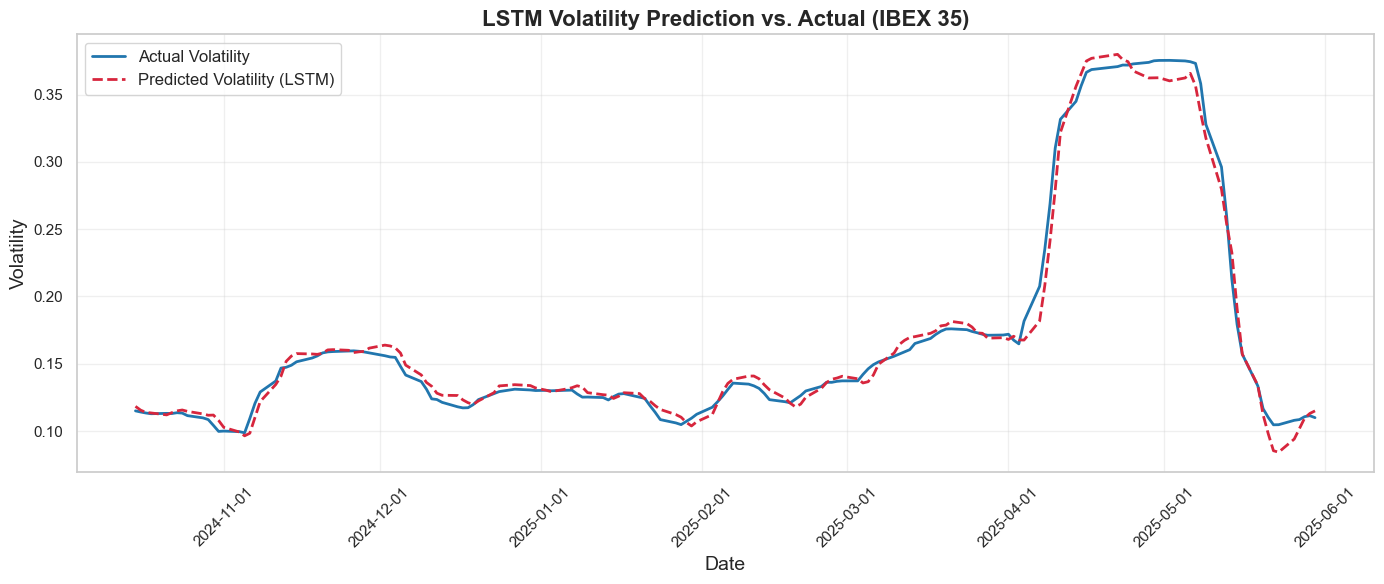

In [7]:
# Run the volatility analysis pipeline
results = run_volatility_pipeline(
    news_df=news_df,
    stock_data=ibex35_data,
    market_name=MARKET_NAME,
    cut_date=CUT,
    epochs=EPOCHS,
)